In [1]:
#from __future__ import division, print_function, absolute_import
import os

import numpy as np
import torch
import torch.nn as nn
import visdom

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from utils.mnist_cached import MNISTCached as MNIST
from utils.mnist_cached import setup_data_loaders
from utils.vae_plots import mnist_test_tsne, plot_llk, plot_vae_samples

from torchvision import transforms, utils, datasets
from PIL import Image
import helperCode

IMG_SIZE = 100*100*3
BATCH_SIZE = 10#32

In [2]:
# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|x)
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Encoder, self).__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(IMG_SIZE, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, IMG_SIZE)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale


# define the PyTorch module that parameterizes the
# observation likelihood p(x|z)
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, IMG_SIZE)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img


# define a PyTorch module for the VAE
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.iarange("data", x.size(0)):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.size(0), self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.size(0), self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).independent(1), obs=x.reshape(-1, IMG_SIZE))
            # return the loc so we can visualize it later
            return loc_img

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.iarange("data", x.size(0)):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img


In [ ]:
more_faces_path = os.path.join(os.path.abspath('..'), "CognitionData", "more_faces")
data_transform = transforms.Compose([
        transforms.ToTensor()
    ])
more_faces_dataset = datasets.ImageFolder(root=more_faces_path, transform=data_transform)
train_loader = torch.utils.data.DataLoader(more_faces_dataset,
                                             batch_size=BATCH_SIZE, shuffle=True,
                                             num_workers=4)



In [3]:
class Args:
    learning_rate = 5e-5#5e-4
    num_epochs = 100#1000
    #hidden_layers = DEFAULT_HIDDEN_DIMS
    #z_dim = DEFAULT_Z_DIM
    #tsne_iter = 100
    #test_frequency = 20
    seed = 10
    beta_1 = 0.900
    aux_loss = True 
    aux_loss_multiplier = 50.0
    cuda=False
    enum_discrete = None #"parallel"#"sequential" #"parallel"
    visdom_flag = False
    #visualize = True
    #logfile = "./tmp.log"
    
args = Args()

# setup the VAE
vae = VAE(use_cuda=args.cuda)

# setup the optimizer
adam_args = {"lr": args.learning_rate}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

# setup visdom for visualization
if args.visdom_flag:
    vis = visdom.Visdom()

train_elbo = []
# training loop
for epoch in range(args.num_epochs):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for batch_num, (x, _) in enumerate(train_loader):
        # if on GPU put mini-batch into CUDA memory
        if args.cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        #print("Batch: ", batch_num, "out of", len(train_loader))
        epoch_loss += svi.step(x)

    # report training diagnostics
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    train_elbo.append(total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

#     if epoch % args.test_frequency == 0:
#         # initialize loss accumulator
#         test_loss = 0.
#         # compute the loss over the entire test set
#         for i, (x, _) in enumerate(test_loader):
#             # if on GPU put mini-batch into CUDA memory
#             if args.cuda:
#                 x = x.cuda()
#             # compute ELBO estimate and accumulate loss
#             test_loss += svi.evaluate_loss(x)

#             # pick three random test images from the first mini-batch and
#             # visualize how well we're reconstructing them
#             if i == 0:
#                 if args.visdom_flag:
#                     plot_vae_samples(vae, vis)
#                     reco_indices = np.random.randint(0, x.size(0), 3)
#                     for index in reco_indices:
#                         test_img = x[index, :]
#                         reco_img = vae.reconstruct_img(test_img)
#                         vis.image(test_img.reshape(28, 28).detach().cpu().numpy(),
#                                   opts={'caption': 'test image'})
#                         vis.image(reco_img.reshape(28, 28).detach().cpu().numpy(),
#                                   opts={'caption': 'reconstructed image'})

#         # report test diagnostics
#         normalizer_test = len(test_loader.dataset)
#         total_epoch_loss_test = test_loss / normalizer_test
#         test_elbo.append(total_epoch_loss_test)
#         print("[epoch %03d]  average test loss: %.4f" % (epoch, total_epoch_loss_test))


[epoch 000]  average training loss: 20785.0417
[epoch 001]  average training loss: 19607.1075
[epoch 002]  average training loss: 18780.3676
[epoch 003]  average training loss: 18199.6898
[epoch 004]  average training loss: 17876.9391
[epoch 005]  average training loss: 17725.7380
[epoch 006]  average training loss: 17651.0411
[epoch 007]  average training loss: 17608.8924
[epoch 008]  average training loss: 17582.0046
[epoch 009]  average training loss: 17563.4671
[epoch 010]  average training loss: 17547.1156
[epoch 011]  average training loss: 17534.8822
[epoch 012]  average training loss: 17524.4388
[epoch 013]  average training loss: 17516.7737
[epoch 014]  average training loss: 17509.0591
[epoch 015]  average training loss: 17502.6769
[epoch 016]  average training loss: 17497.8039
[epoch 017]  average training loss: 17491.9060
[epoch 018]  average training loss: 17486.8431
[epoch 019]  average training loss: 17483.1913
[epoch 020]  average training loss: 17479.6082
[epoch 021]  

Process Process-350:
Process Process-351:
Process Process-352:
Process Process-349:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
    self.run()
    self.run()
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/System/Library/Frameworks/Python.framework/Versions/2.

KeyboardInterrupt: 

In [3]:
x.shape

torch.Size([10, 3, 100, 100])

In [ ]:
# Todo: add description, save/load model state. visualize

In [4]:
samples = vae.reconstruct_img(x).view(x.shape[0], 3, 100, 100)

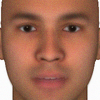

In [5]:
i=5
sample = samples[i,:,:,:]
sample = sample.detach().numpy()
sample = np.array(sample*255., dtype='uint8')
sample = sample.transpose((1, 2, 0))
Image.fromarray(sample)